In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from docplex.mp.model import Model
from tensorflow import keras        
class EnergyStorage:
    def __init__(self, name, maxPower, initTermSOC, maxCapacity, chgEfficiency, disEfficiency):
        self.name = name
        self.maxPower = maxPower
        self.initSOC = initTermSOC[0]
        self.termSOC = initTermSOC[1]
        self.maxCapacity = maxCapacity
        self.chgEfficiency = chgEfficiency
        self.disEfficiency = disEfficiency

In [114]:
##### load and pv prediction 

# upload 0629 INPUT DATA
load_0629 = pd.read_csv('climate_2022_0629_0809.csv', encoding = 'cp949')
load_0629 = load_0629.fillna(0)
a = load_0629.iloc[:24,[1, 4]]

X_0629_for_Load_prediction = []
for i in range(24):
    X_0629_for_Load_prediction.append([i]+list(a.iloc[i,:]))

b = load_0629.iloc[:24,[1, 4 ,6, 7]]    
X_0629_for_PV_prediction =[]
for i in range(24):
    X_0629_for_PV_prediction.append(list(b.iloc[i,:]))


1/1 [==============================] - 0s 81ms/step
Predicted net load is 
  [16242.515, 15950.602, 15821.809, 15734.254, 15543.298, 15261.831, 14876.832, 15018.617, 16347.411, 18128.76, 19614.744, 20828.057, 20275.754, 20387.14, 20652.43, 19986.326, 19661.85, 19642.17, 18970.096, 18273.002, 17364.125, 17010.537, 16552.426, 16491.639]


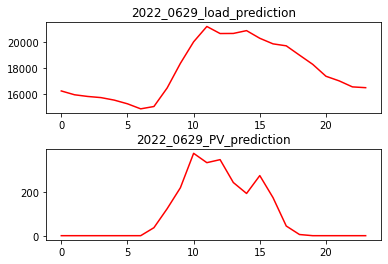

In [116]:
#predict load and PV with saved model
load_prediction_model = keras.models.load_model('load_prediction_Junely2.tf')
load_predict = load_prediction_model.predict(X_0629_for_Load_prediction)

PV_prediction_model = keras.models.load_model('best-model_June_July5.tf')
PV_predict = PV_prediction_model.predict(X_0629_for_PV_prediction)

fig, axs = plt.subplots(2,1)
axs[0].plot(load_predict,'r')
axs[0].set_title('2022_0629_load_prediction')
axs[1].plot(PV_predict,'r')
axs[1].set_title('2022_0629_PV_prediction')
plt.subplots_adjust(hspace=0.4)

#predicted net load
predicted_net_load = load_predict - PV_predict
predicted_net_load = [predicted_net_load[i][0] for i in range(24)]
print("Predicted net load is \n ", predicted_net_load)

In [117]:
#Seasonal electricity bill sheet
spring_fall_price = [38.8 for i in range(9)]+[53.0]+[72.8 for i in range(2)]+[53.0]+[72.8 for i in range(4)]+[53.0 for i in range(6)]+[38.8]
summer_price = [38.8 for i in range(9)]+[82.3]+[145.2 for i in range(2)]+[82.3]+[145.2 for i in range(4)]+[82.4 for i in range(6)]+[38.8]
winter_price = [42.6 for i in range(9)]+[80.6]+[117.9 for i in range(2)]+[80.6 for i in range(5)]+[117.9 for i in range(3)]+[80.6 for i in range(2)]+[117.9, 42.6]
month = 6
if (6 <= month)&(month<=8):
    price = summer_price
elif (11<=month)|(month<=2):
    price = winter_price
else:
    price = spring_fall_price

#Predicted load (considering PV generation)
load = predicted_net_load 

SOC_ESS_MIN = 0.2
SOC_ESS_MAX = 0.8
SOC_ESS_INIT = 0.5
SOC_ESS_TERM = 0.5
chgEfficiency = 1
disEfficiency = 0.93
maxPower = 1000   #BESS 용량을 1000kw/7500kwh 라고 가정하였습니다.
maxCapacity = 7500

gistEss = EnergyStorage('gistESS', maxPower, [SOC_ESS_INIT, SOC_ESS_TERM], maxCapacity, chgEfficiency, disEfficiency)

### Set number of variables
nTimeslot = len(load)

In [149]:
price

[38.8,
 38.8,
 38.8,
 38.8,
 38.8,
 38.8,
 38.8,
 38.8,
 38.8,
 82.3,
 145.2,
 145.2,
 82.3,
 145.2,
 145.2,
 145.2,
 145.2,
 82.4,
 82.4,
 82.4,
 82.4,
 82.4,
 82.4,
 38.8]

In [119]:
m = Model(name='Unit Commitment')

# 변수 생성
P_essChg = m.continuous_var_list(nTimeslot, lb=0, ub=maxPower)
P_essDis = m.continuous_var_list(nTimeslot, lb=0, ub=maxPower)
U_essChg = m.binary_var_list(nTimeslot)
U_essDis = m.binary_var_list(nTimeslot)

########## 제약조건 ##########
for i in range(nTimeslot):
    m.add_constraint( P_essDis[i] <= U_essDis[i]*gistEss.maxPower )# 최대출력 제약
    m.add_constraint( P_essChg[i] <= U_essChg[i]*gistEss.maxPower )# 최대출력 제약
    m.add_constraint( U_essDis[i] + U_essChg[i] <= 1 ) #동시 충방전 방지
    m.add_constraint( P_essDis[i] <= load[i] ) #부하 이상의 전력은 방전 불가.
    
### SOC 제약 ###
#최대(0.8) 최소(0.2) SOC 제약
for i in range(nTimeslot):
        m.add_constraint( gistEss.initSOC
                          - sum(P_essDis[k]/gistEss.disEfficiency/gistEss.maxCapacity
                                for k in range(i + 1))
                          + sum(P_essChg[k]*gistEss.chgEfficiency/gistEss.maxCapacity
                                for k in range(i + 1)) <=  SOC_ESS_MAX )
        m.add_constraint( gistEss.initSOC
                          - sum(P_essDis[k]/gistEss.disEfficiency/gistEss.maxCapacity
                                for k in range(i + 1))
                          + sum(P_essChg[k]*gistEss.chgEfficiency/gistEss.maxCapacity
                                for k in range(i + 1)) >=  SOC_ESS_MIN )
        
#24시간마다 termSOC(0.5) 유지 제약
m.add_constraint(gistEss.initSOC 
                 - sum(P_essDis[k]/gistEss.disEfficiency/gistEss.maxCapacity for k in range(nTimeslot))
                 + sum(P_essChg[k]*gistEss.chgEfficiency/gistEss.maxCapacity for k in range(nTimeslot))
                 ==  gistEss.termSOC )
    



docplex.mp.LinearConstraint[](0.000x1+0.000x2+0.000x3+0.000x4+0.000x5+0.000x6+0.000x7+0.000x8+0.000x9+0.000x10+0.000x11+0.000x12+0.000x13+0.000x14+0.000x15+0.000x16+0.000x17+0.000x18+0.000x19+0.000x20+0.000x21+0.000x22+0.000x23+0.000x24-0.000x25-0.000x26-0.000x27-0.000x28-0.000x29-0.000x30-0.000x31-0.000x32-0.000x33-0.000x34-0.000x35-0.000x36-0.000x37-0.000x38-0.000x39-0.000x40-0.000x41-0.000x42-0.000x43-0.000x44-0.000x45-0.000x46-0.000x47-0.000x48+0.500,EQ,0.5)

In [120]:
### 목적함수
m.set_objective("min", sum((load[i]+P_essChg[i]-P_essDis[i])*price[i] for i in range(24)))
                               
m.print_information()
sol = m.solve()
print(m.objective_value)

### Solution 저장

P_essDisSol = np.zeros([nTimeslot])
P_essChgSol = np.zeros([nTimeslot])
U_essDisSol = np.zeros([nTimeslot])
U_essChgSol = np.zeros([nTimeslot])

socEss = np.zeros([nTimeslot])
for i in range(nTimeslot):
        P_essDisSol[i] = sol.get_value(P_essDis[i])
        P_essChgSol[i] = sol.get_value(P_essChg[i])
        U_essDisSol[i] = sol.get_value(U_essDis[i])
         
        U_essChgSol[i] = sol.get_value(U_essChg[i])
        socEss[i] = (gistEss.initSOC 
                        - sum(P_essDisSol[k]/gistEss.disEfficiency/gistEss.maxCapacity for k in range(i + 1)) 
                        + sum(P_essChgSol[k]*gistEss.chgEfficiency/gistEss.maxCapacity for k in range(i + 1)))

Model: Unit Commitment
 - number of variables: 96
   - binary=48, integer=0, continuous=48
 - number of constraints: 145
   - linear=145
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP
35304092.66972655


[ -250. -1000. -1000.     0.     0.     0.     0.     0.     0.     0.
  1000.  1000. -1000.  1000.  1000.  1000.   115.  -250.     0.     0.
     0.     0. -1000. -1000.]


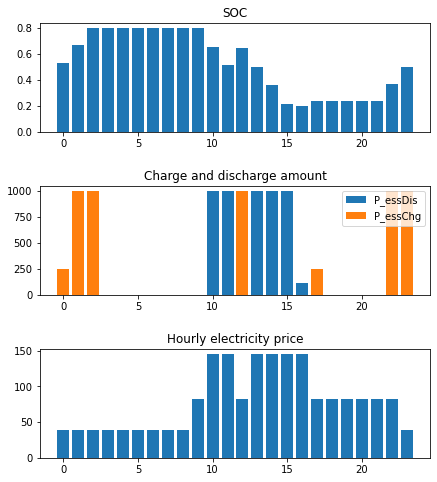

In [146]:
hours = np.arange(24)
fig, axs = plt.subplots(3,1, figsize = (7,8))
axs[0].bar(hours, socEss)
axs[0].set_title('SOC')
axs[1].bar(hours, P_essDisSol, label='P_essDis')
axs[1].bar(hours, P_essChgSol, label='P_essChg')
axs[1].legend()
axs[1].set_title('Charge and discharge amount')
axs[2].bar(hours, price)
axs[2].set_title('Hourly electricity price')
plt.subplots_adjust(hspace=0.5)
print(P_essDisSol-P_essChgSol)

In [148]:
load_predict

array([[16242.517],
       [15950.604],
       [15821.811],
       [15734.256],
       [15543.301],
       [15261.834],
       [14876.835],
       [15055.248],
       [16471.184],
       [18348.62 ],
       [19992.418],
       [21162.854],
       [20624.404],
       [20630.926],
       [20845.986],
       [20261.896],
       [19836.295],
       [19686.467],
       [18975.436],
       [18273.006],
       [17364.127],
       [17010.54 ],
       [16552.428],
       [16491.64 ]], dtype=float32)

In [147]:
PV_predict

array([[2.39221007e-03],
       [2.40913406e-03],
       [2.38292664e-03],
       [2.36250833e-03],
       [2.45207548e-03],
       [2.78840959e-03],
       [3.28526646e-03],
       [3.66307373e+01],
       [1.23771996e+02],
       [2.19858932e+02],
       [3.77674316e+02],
       [3.34796783e+02],
       [3.48651093e+02],
       [2.43785370e+02],
       [1.93556580e+02],
       [2.75569550e+02],
       [1.74445206e+02],
       [4.42978172e+01],
       [5.34018660e+00],
       [3.05193663e-03],
       [2.44216621e-03],
       [2.43936479e-03],
       [2.35953927e-03],
       [2.44776905e-03]], dtype=float32)